In [1]:
%run ../_config/config.py # Import the configuration settings
import logging

import cmdstanpy

cmdstanpy.utils.get_logger().setLevel(logging.ERROR)
from cmdstanpy import CmdStanModel
import seaborn as sns
import pingouin as pg

In [2]:
df = pd.read_csv('../data/Howell_18.csv')
df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


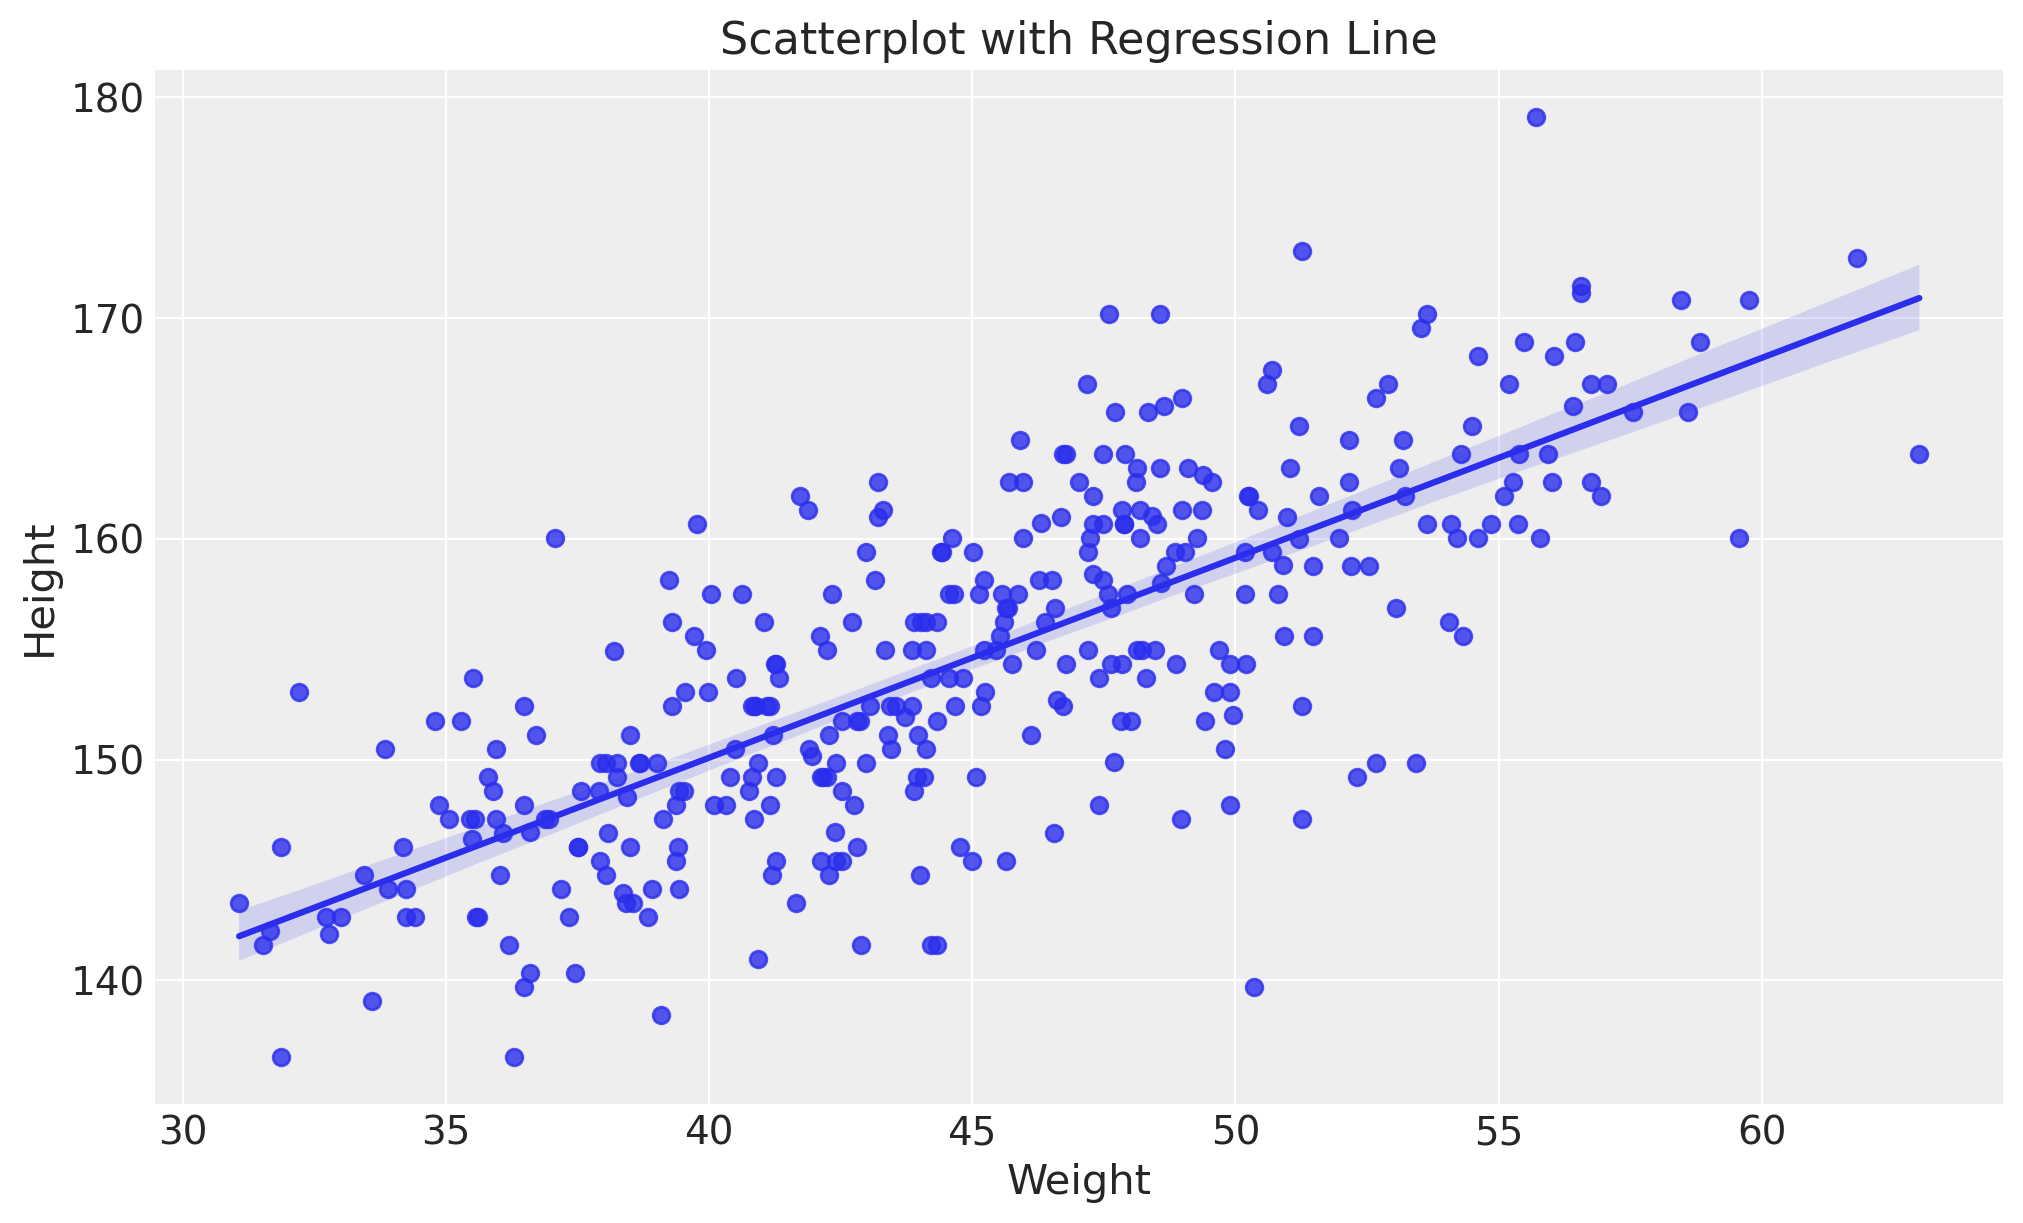

In [3]:
# Create the scatterplot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='weight', y='height', data=df)
plt.title('Scatterplot with Regression Line')
plt.xlabel('Weight')
plt.ylabel('Height')
plt.show()

In [4]:
stan_file = os.path.join(project_directory, 'stan', 'linreg_height.stan')
model = CmdStanModel(stan_file=stan_file)
print(model.code())

data {
  int<lower=1> N;
  vector[N] x;
  vector[N] y;
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
model {
  y ~ normal(alpha + beta * (x- mean(x)), sigma);
  alpha ~ normal(181, 30);
  beta ~ normal(-2, 2);
  sigma ~ normal(0, 20);
}
generated quantities {
  array[N] real y_rep = normal_rng(alpha + beta * x, sigma);
}



In [5]:
stan_data = {
    "N": len(df["height"]),
    "x": df["weight"] - np.mean(df["weight"]),
    "y": df["height"]
}

In [6]:
fit = model.sample(
    data=stan_data,
    iter_warmup=1_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False
)

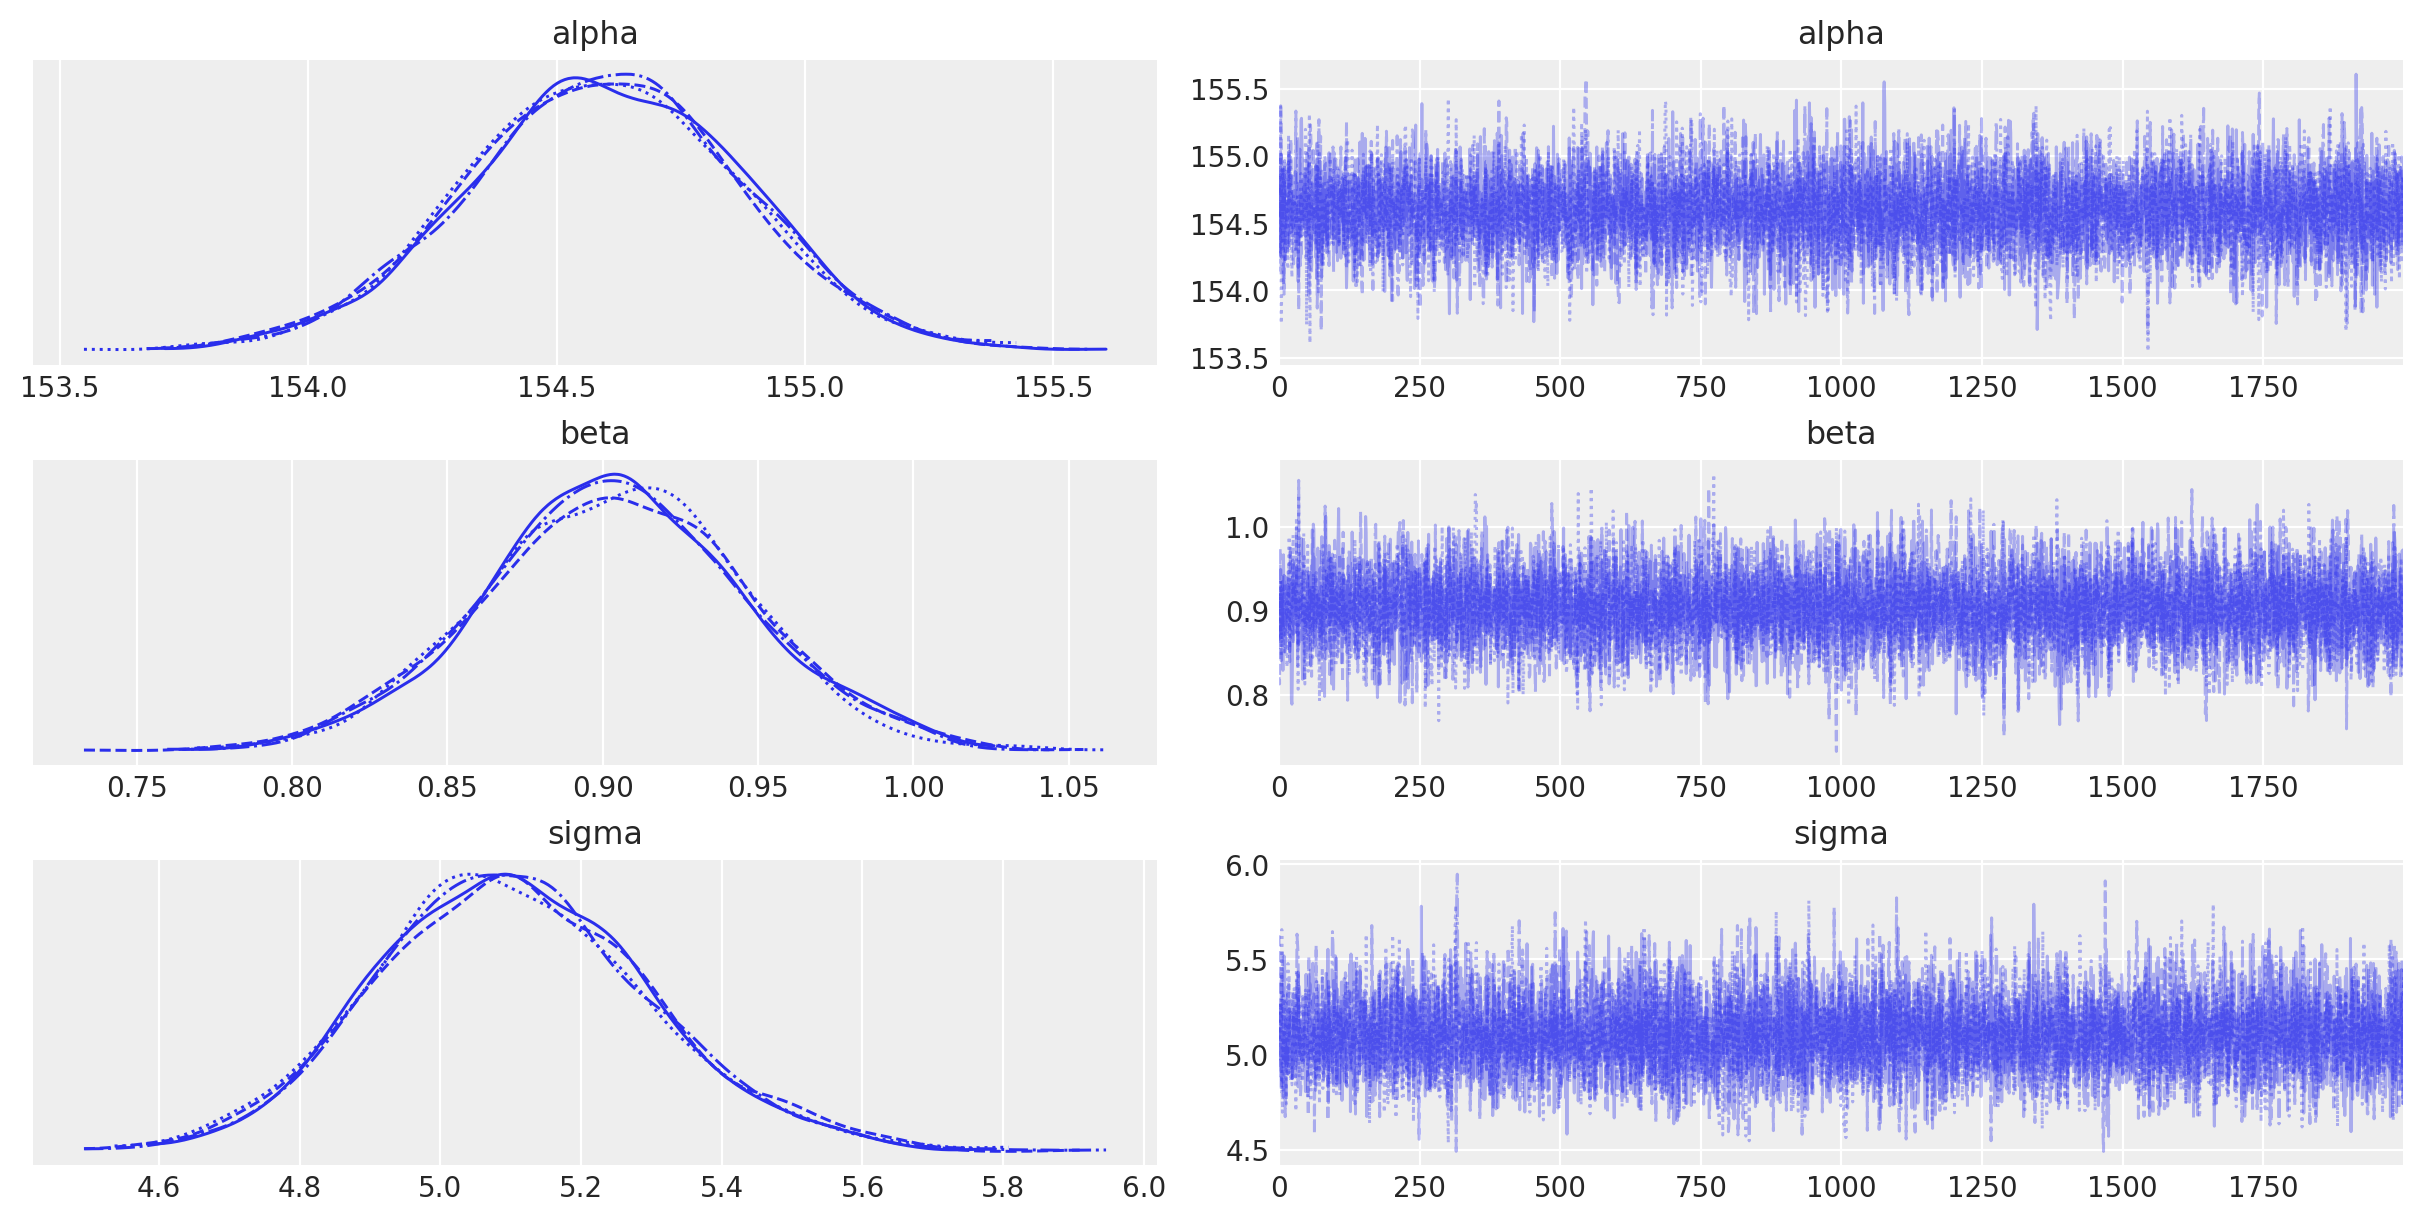

In [7]:
_ = az.plot_trace(fit, var_names=(["alpha", "beta", "sigma"]))

In [8]:
az.summary(fit, var_names=(["alpha", "beta", "sigma"]), hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,154.594,0.278,154.066,155.112,0.003,0.002,7707.0,5702.0,1.0
beta,0.904,0.042,0.823,0.983,0.000,0.000,8612.0,6334.0,1.0
sigma,5.104,0.195,4.747,5.482,0.002,0.002,8641.0,6071.0,1.0


In [9]:
lm = pg.linear_regression(df["weight"] - np.mean(df["weight"]), df["height"])
lm.round(2)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,154.60,0.27,570.25,0.0,0.57,0.57,154.06,155.13
1,weight,0.91,0.04,21.52,0.0,0.57,0.57,0.82,0.99


In [10]:
idata = az.from_cmdstanpy(
    posterior=fit,
    posterior_predictive='y_rep',
    observed_data={'y': df["height"]},
)

/opt/anaconda3/envs/cmdstan_env/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


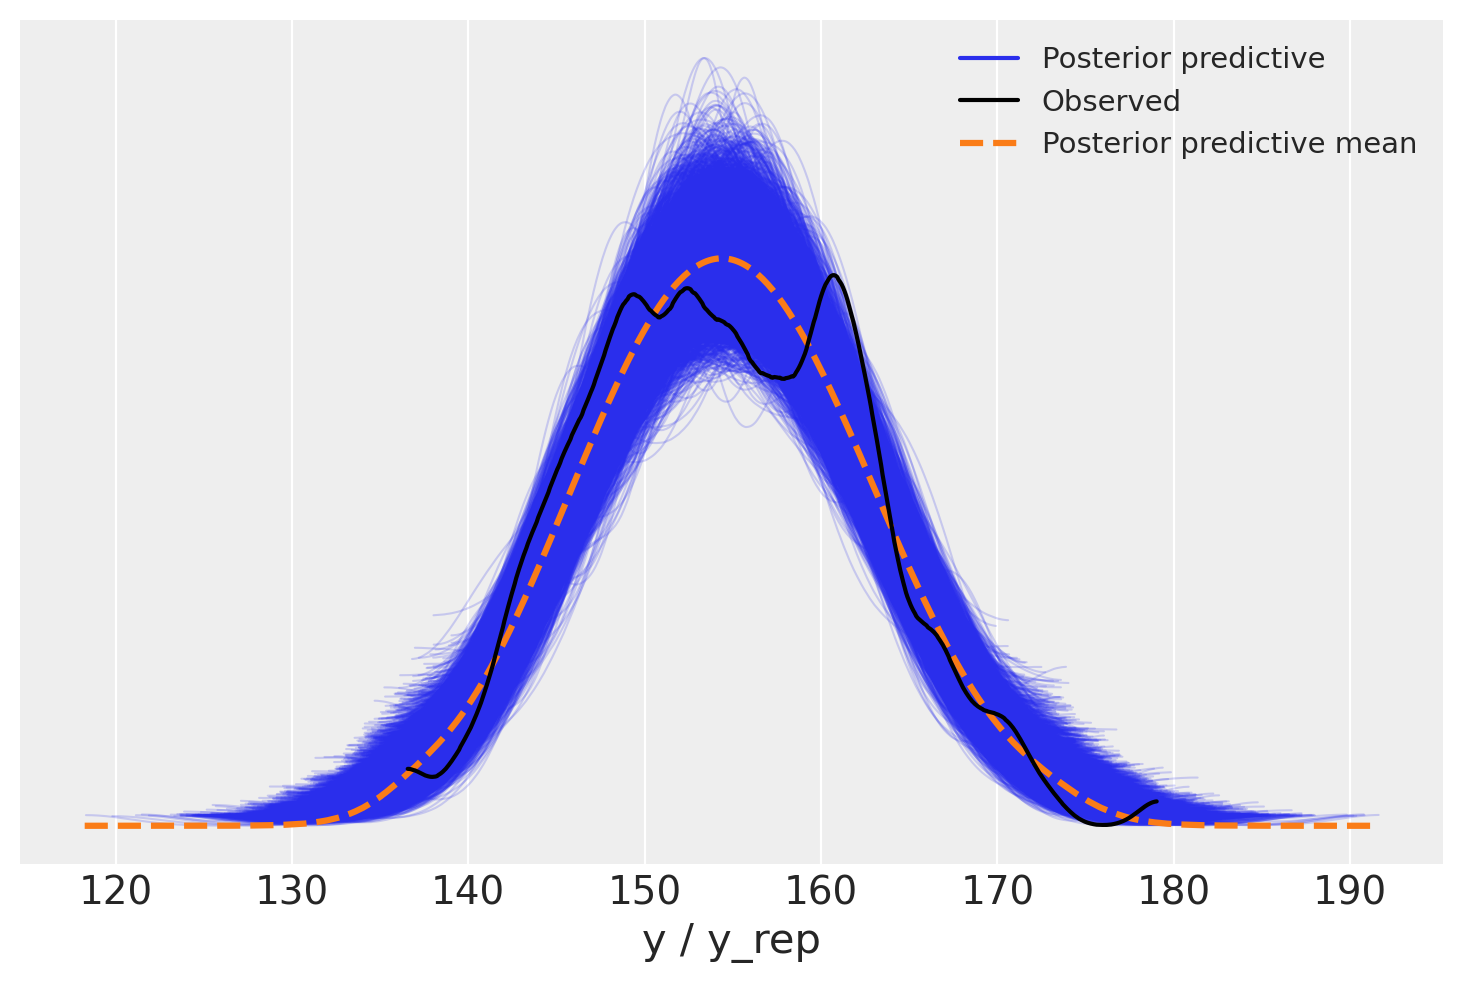

In [11]:
_ = az.plot_ppc(idata, data_pairs={'y': 'y_rep'})

In [12]:
# Extract posterior samples
alpha_samples = fit.stan_variable("alpha")
beta_samples = fit.stan_variable("beta")

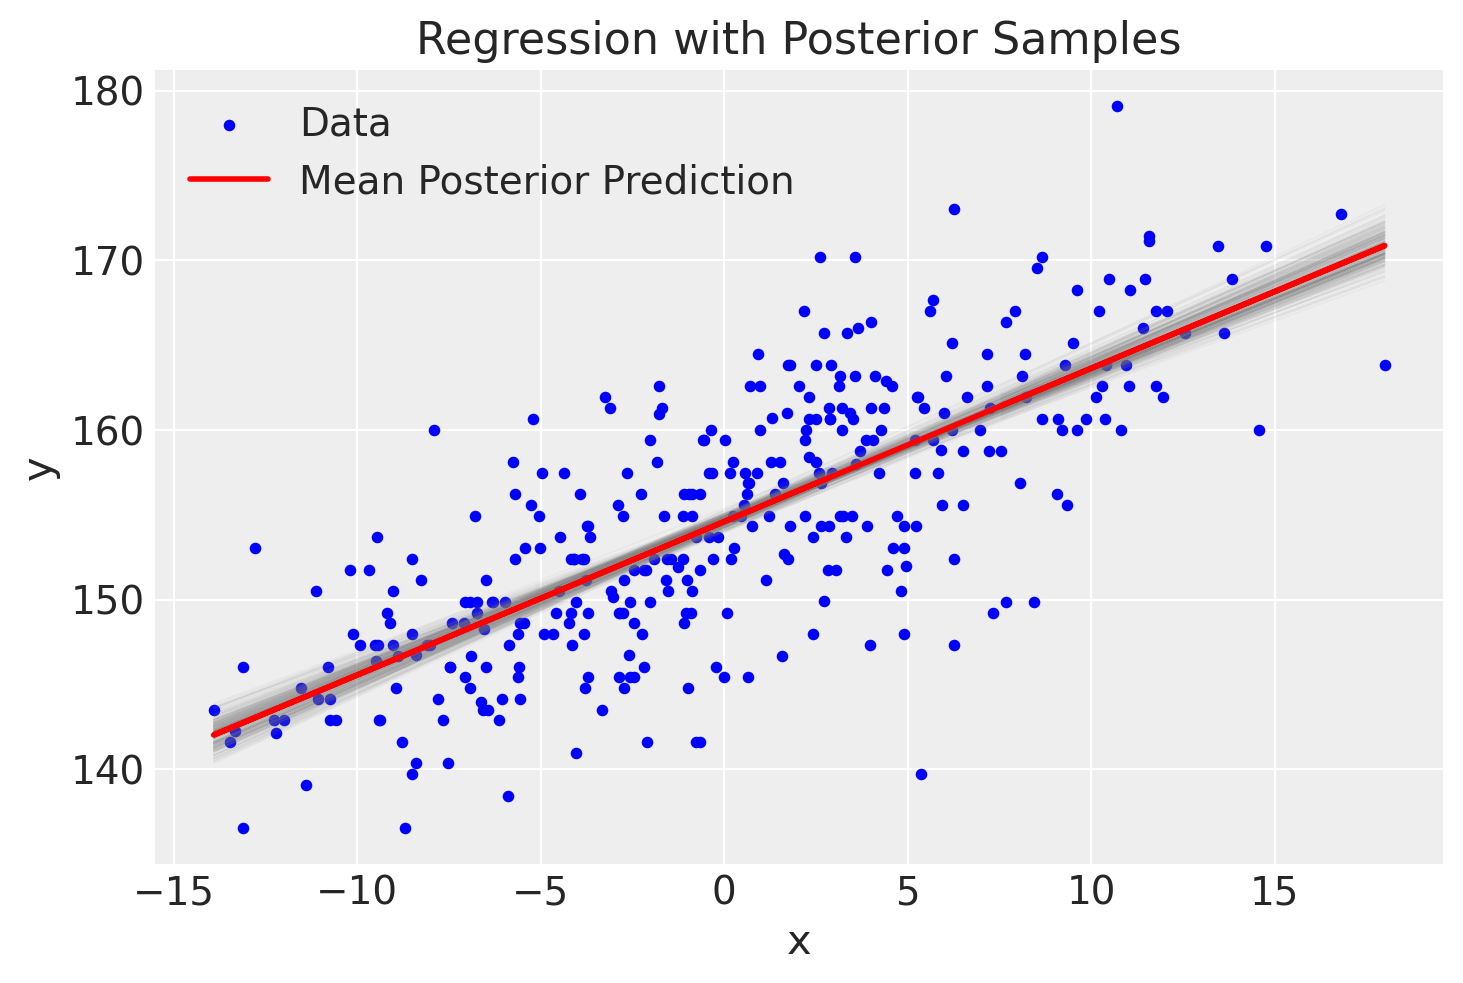

In [13]:
# Plot y vs x
x = df["weight"] - np.mean(df["weight"])
plt.scatter(x, df["height"], color="blue", label="Data", s=10)  # s is the size of the point

# Draw lines from posterior samples
for i in range(300):  # assuming you have at least 300 samples
    plt.plot(
        x,
        alpha_samples[i] + beta_samples[i] * x,
        color="gray",
        linestyle="-",
        linewidth=0.5,
        alpha=0.05,
    )

# Line using the mean of posterior estimates
mean_alpha = np.mean(alpha_samples)
mean_beta = np.mean(beta_samples)
plt.plot(
    x,
    mean_alpha + mean_beta * x,
    color="red",
    linewidth=2,
    label="Mean Posterior Prediction",
)

# Additional plot formatting
plt.xlabel("x")
plt.ylabel("y")
plt.title("Regression with Posterior Samples")
plt.legend()
plt.show()

In [14]:
%load_ext watermark
%watermark -n -u -v -iv -m

Last updated: Sun Jun 16 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

pandas    : 2.2.2
matplotlib: 3.8.4
arviz     : 0.18.0
numpy     : 1.26.4
seaborn   : 0.13.2
pingouin  : 0.5.4
logging   : 0.5.1.2
cmdstanpy : 1.2.3

